### **Setting up Colab :**

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# **Install Pytorch Retinanet and Dependencies** :

In [ ]:
!pip install -Uqq pytorch-lightning==1.0.0 omegaconf
!pip install -Uqq git+https://github.com/albumentations-team/albumentations
!pip uninstall torchtext
!git clone https://github.com/benihime91/pytorch_retinanet.git

     |████████████████████████████████| 510 kB 4.9 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 65.5 MB/s 
     |████████████████████████████████| 829 kB 41.8 MB/s 
     |████████████████████████████████| 136 kB 48.0 MB/s 
     |████████████████████████████████| 112 kB 58.2 MB/s 
     |████████████████████████████████| 47.8 MB 1.7 MB/s 
Found existing installation: torchtext 0.12.0
Uninstalling torchtext-0.12.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchtext-0.12.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchtext/*
Proceed (y/n)? y
  Successfully uninstalled torchtext-0.12.0
Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 2137, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 2137 (delta 56), reused 31 (delta 15), pack-reused 2032
Receiving objects: 100% (2137/2137), 84.65 MiB | 26.06 MiB/s, done.
Reso

In [ ]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content
!curl -L "[YOUR OWN LINK HERE]" > roboflow.zip; unzip -qq roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   1178      0 --:--:-- --:--:-- --:--:--  1178
100 6087k  100 6087k    0     0  4901k      0  0:00:01  0:00:01 --:--:-- 20.9M


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9OCwsGpPW42KDaX86rtZ")
project = rf.workspace("class-eeviu").project("filtre_dataset")
dataset = project.version(1).download("voc")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to filtre_dataset-1 in voc::   0%|          | 0/8971 [00:00<?, ?it/s]
Extracting Dataset Version Zip to filtre_dataset-1 in voc::   2%|▏         | 158/8971 [00:00<00:05, 1536.14it/s]
Extracting Dataset Version Zip to filtre_dataset-1 in voc::   4%|▎         | 318/8971 [00:00<00:05, 1563.09it/s]
Extracting Dataset Version Zip to filtre_dataset-1 in voc::   5%|▌         | 475/8971 [00:00<00:05, 1523.60it/s]
Extracting Dataset Version Zip to filtre_dataset-1 in voc::   7%|▋         | 628/8971 [00:00<00:06, 1232.85it/s]
Extracting Dataset Version Zip to filtre_dataset-1 in voc::   9%|▊         | 765/8971 [00:00<00:06, 1273.44it/s]
Extracting Dataset Version Zip to filtre_dataset-1 in voc::  10%|█         | 903/8971 [00:00<00:06, 1305.56it/s]
Extracting Dataset Version Zip to filtre_dataset-1 in voc::  12%|█▏        | 1038/8971 [00:00<00:06, 1303.19it/s]
Extracting Dataset Version Zip to filtre_dataset-1 in voc::  13%|█▎        | 1190/8971 [00:00<00:05, 1368.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Set up paths 

#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/filtre_dataset/train"
VALID_IMAGE_PATH = "/content/filtre_dataset/valid"
TEST_IMAGE_PATH  = "/content/filtre_dataset/test"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/content/filtre_dataset/train"
VALID_ANNOT_PATH = "/content/filtre_dataset/valid"
TEST_ANNOT_PATH  = "/content/filtre_dataset/test"

In [ ]:
!pip install opencv-python-headless==4.5.2.52



     |████████████████████████████████| 38.2 MB 1.3 MB/s 


In [ ]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np

from utils.pascal import convert_annotations_to_df

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

## **Generate csv file from XML Annotations:**

In [ ]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOT_PATH, VALID_IMAGE_PATH, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")


def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

### **CSV Files are as follows :**

In [ ]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/filtre_dataset/train/TCGA-A2-A0T0-01Z-00-DX1-51F904DA-A4B5-4451-8AEF-58E7EF7651DB_-37706--30112--37841--30249-_png_jpg.rf.86d15887d0b06209928d47c12ffd4479.jpg,416,416,lymphocytes and plasma cells,351,369,403,416,1
1,/content/filtre_dataset/train/TCGA-BH-A0B9-01Z-00-DX1-c23adb4c-52d4-4dfd-b8e3-156e43f0e645_-32126--31286--32261--31429-_png_jpg.rf.ee2c4794c31be3d4c58e0829e288a983.jpg,416,416,lymphocytes and plasma cells,373,336,412,388,1
2,/content/filtre_dataset/train/TCGA-BH-A0B9-01Z-00-DX1-c23adb4c-52d4-4dfd-b8e3-156e43f0e645_-32126--31286--32261--31429-_png_jpg.rf.ee2c4794c31be3d4c58e0829e288a983.jpg,416,416,lymphocytes and plasma cells,344,89,392,141,1
3,/content/filtre_dataset/train/TCGA-BH-A0B9-01Z-00-DX1-c23adb4c-52d4-4dfd-b8e3-156e43f0e645_-32126--31286--32261--31429-_png_jpg.rf.ee2c4794c31be3d4c58e0829e288a983.jpg,416,416,lymphocytes and plasma cells,333,264,381,316,1
4,/content/filtre_dataset/train/TCGA-BH-A0B9-01Z-00-DX1-c23adb4c-52d4-4dfd-b8e3-156e43f0e645_-32126--31286--32261--31429-_png_jpg.rf.ee2c4794c31be3d4c58e0829e288a983.jpg,416,416,lymphocytes and plasma cells,334,42,382,94,1


In [ ]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/filtre_dataset/valid/TCGA-S3-AA15-01Z-00-DX1-A2456A4A-E6E8-4429-8F09-B997AA497BB0_-28372--14968--28525--15111-_png_jpg.rf.803ec639cb9275067222b0d098496f2f.jpg,416,416,lymphocytes and plasma cells,306,356,349,402,1
1,/content/filtre_dataset/valid/201B_-58431--8953--59631--10143-_png_jpg.rf.10cdc5dd574c12e1fca26deb2c0477bd.jpg,416,416,lymphocytes and plasma cells,20,2,26,8,1
2,/content/filtre_dataset/valid/201B_-58431--8953--59631--10143-_png_jpg.rf.10cdc5dd574c12e1fca26deb2c0477bd.jpg,416,416,lymphocytes and plasma cells,218,5,224,11,1
3,/content/filtre_dataset/valid/201B_-58431--8953--59631--10143-_png_jpg.rf.10cdc5dd574c12e1fca26deb2c0477bd.jpg,416,416,lymphocytes and plasma cells,64,5,70,11,1
4,/content/filtre_dataset/valid/201B_-58431--8953--59631--10143-_png_jpg.rf.10cdc5dd574c12e1fca26deb2c0477bd.jpg,416,416,lymphocytes and plasma cells,26,5,32,12,1


In [ ]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/filtre_dataset/test/TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-15993--10614--16141--10770-_png_jpg.rf.33b10413e2f6376bdac132ea49120e0a.jpg,416,416,lymphocytes and plasma cells,15,49,60,92,1
1,/content/filtre_dataset/test/TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-15993--10614--16141--10770-_png_jpg.rf.33b10413e2f6376bdac132ea49120e0a.jpg,416,416,lymphocytes and plasma cells,66,81,111,124,1
2,/content/filtre_dataset/test/TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-15993--10614--16141--10770-_png_jpg.rf.33b10413e2f6376bdac132ea49120e0a.jpg,416,416,lymphocytes and plasma cells,268,166,313,209,1
3,/content/filtre_dataset/test/TCGA-AN-A0XU-01Z-00-DX1-6B0DD0FF-A20D-4BA2-8D48-FC357BA5313F_-15993--10614--16141--10770-_png_jpg.rf.33b10413e2f6376bdac132ea49120e0a.jpg,416,416,lymphocytes and plasma cells,4,190,49,233,1
4,/content/filtre_dataset/test/TCGA-BH-A18G-01Z-00-DX1-DB2B5819-CE83-4E07-BD03-2CD9CF2E246C_-8543--1377--8681--1535-_png_jpg.rf.d0b8aa0533c33dbbe8a18441f54952eb.jpg,416,416,lymphocytes and plasma cells,252,51,300,93,1


In [ ]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV  = "/content/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

# **View Images from the Dataset** :

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

##**Generate the Label Map which is used for visualization:**

In [ ]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 'lymphocytes and plasma cells']

##**Plot images with Bounding boxes over them**:

In [ ]:
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index

    Params
    ------
        dataframe : a pandas dataframe object
        index (int) : a integer corresponding to a index in the pandas dataframe

    Returns
    -------
        fname (str) : path to the selected image.
        bbbs (list) : a list containing the bounding box annotations for the `fname`.
        cls (list) : a list containing the integer class labels for the box annotations.  
    """
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values
    return fname, bbs, cls



In [ ]:
def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

### **Image from Train Data:**

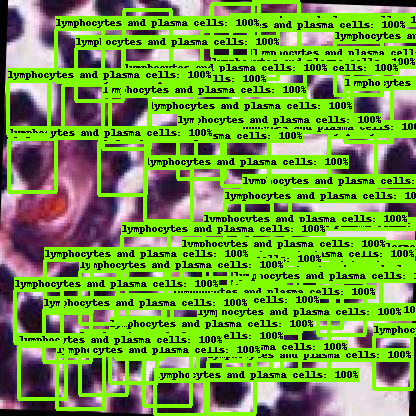

In [ ]:
image = load_image_from_data(train_df, index=10)
image

### **Image from Validation data:**

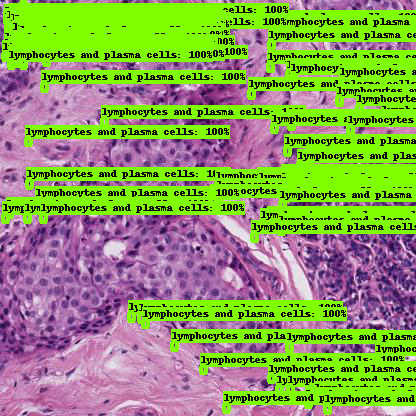

In [ ]:
image = load_image_from_data(valid_df, index=10)
image

###**Image from Test Data:**

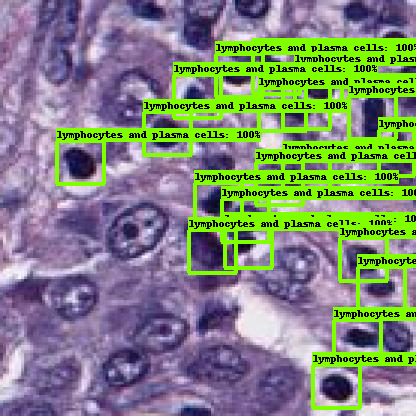

In [ ]:
image = load_image_from_data(test_df, index=5)
image

#**Configure Custom PyTorch RetianNet Object Detection Training Configuration** :

The configuration file is present in `/content/pytorch_retinanet/hparams.yaml`.


In [ ]:
NUM_TRAIN_EPOCHS = 50


from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV

hparams.dataloader.train_bs = 32
hparams.dataloader.valid_bs = 32
hparams.dataloader.test_bs  = 32

hparams.model.num_classes   = 1 
hparams.model.backbone_kind = "resnet34"
hparams.model.min_size      = 416
hparams.model.max_size      = 416
hparams.model.pretrained    = True #loads in imagenet-backbone weights

#transforms for the train_dataset
hparams.transforms  =  [
    #{"class_name": "albumentations.HorizontalFlip", "params": {"p": 0.5} },
    #{"class_name": "albumentations.ShiftScaleRotate", "params": {"p": 0.5} },
    #{"class_name": "albumentations.RandomBrightnessContrast", "params": {"p": 0.5} },
]

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD", 
    "params"    : {"lr": 0.001, "weight_decay": 0.0005, "momentum":0.9},
    }

#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.CosineAnnealingLR", 
    "params"     : {"T_max": NUM_TRAIN_EPOCHS}, 
    "monitor"    : None, 
    "interval"   : "epoch", 
    "frequency"  : 1
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet34
  num_classes: 1
  freeze_bn: true
  min_size: 416
  max_size: 416
  pretrained: true
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train_data.csv
  valid_paths: /content/valid_data.csv
  test_paths: /content/test_data.csv
dataloader:
  train_bs: 32
  valid_bs: 32
  test_bs: 32
  args:
    num_workers: 0
    pin_memory: true
transforms: []
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.001
    weight_decay: 0.0005
    momentum: 0.9
scheduler:
  class_name: torch.optim.lr_scheduler.CosineAnnealingLR
  params:
    T_max: 50
  monitor: null
  interval: epoch
  frequency: 1



#**Instantiate Lightning-Module and Lightning-Trainer**

In [ ]:
import torch.hub
print(torchvision.__version__)


0.12.0+cu113


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

from model import RetinaNetModel

# seed so that results are reproducible
pl.seed_everything(123)

123

## **Load in the Lighning-Trainer :**

In [ ]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE: 
# For a list of whole trainer specific arguments see : 
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

lr_logger  = LearningRateMonitor(logging_interval="step")

#instantiate LightningTrainer
trainer    = Trainer(precision=16, gpus=1, callbacks=[lr_logger], max_epochs=NUM_TRAIN_EPOCHS)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


##**Load in the Lighning-Module using the hparams file modified above & Start Train :**

In [ ]:
# Instantiate lightning-module
litModel = RetinaNetModel(conf=hparams)

BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=416, MIN_SIZE=416
NUM_CLASSES  : 1


In [ ]:
trainer.fit(litModel)


  | Name | Type      | Params
-----------------------------------
0 | net  | Retinanet | 29 M  


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

#**Evaluating the trained-model using COCO-API Metrics** : 

In [ ]:
trainer.test(litModel)

# **Export the model weights** :

In [ ]:
import torch
PATH = f"/content/drive/My Drive/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

In [ ]:
import torch
PATH = f"/content/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

#**Load PyTorch Model from the trained Lightning-Module weights :**

In [ ]:
import logging
logger = logging.getLogger("lightning")

In [ ]:
from retinanet import Retinanet

#load saved model state dict
state_dict = torch.load(PATH)
#model arguments same as the arguments used to train the model
model_args = hparams.model
#load pytorch model without the lightning-module
#using args and state dict
MODEL      = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=416, MIN_SIZE=416
NUM_CLASSES  : 1


# **Run Inference on Test Images with Custom PyTorch Object Detector**

In [ ]:
from PIL import Image
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.

    Params
    ------
        image_path (str) : Path to the input Image
        threshold (float): Score threshold to filter predictions

    Returns
    -------
        A Dictionary contatining the predictions from generated from the model on 
        the given image. 
        Keys of the dictionary: 
          - "boxes" : bounding-box co-ordinates
          - "labels": class labels for the bounding box co-ordinates.
          - "scores": scores for the bounding box co-ordinates.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    INFER_TRANSFORMS = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True)
        ])
    
    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS  = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in 
    the given image path

    Params
    ------
        image_path `(str)` : Path to the input Image
        threshold `(float)`: Score threshold to filter predictions
    
    Returns
    -------
        boxes  `(np.array)`: filtered absolute bounding box co-ordinates.
        labels `(np.array)`: class labels for the bounding box co-ordinates.
        scores `(np.array)`: scores for the bounding box co-ordinates.
    """
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask   = scores > threshold
    boxes  = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

def draw_on_image(image_path, boxes, scores, classes, label_map=LABEL_MAP):
    """
    Draw bounding box over the image at image path, with the scores and classes
    Returns a PIL image object.
    
    Params
    ------ 
        image_path `(str)`   : Path to the input Image
        boxes `(List[N,4])`  : absolute bouding box co-ordiates in the form `[xmin,ymin,xmax,ymax]`.
        scores `(List[N])`   : List containing the scores for each of the bounding box.
        classes `(`List[N])` : List containing the class_labels for each of the bounding box.
        label_map `(List)`   : List of the labels

    Returns
    -------
        A PIL Image object
    """
    image = Image.open(image_path)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=scores, classes=classes, label_map=LABEL_MAP)
    return image

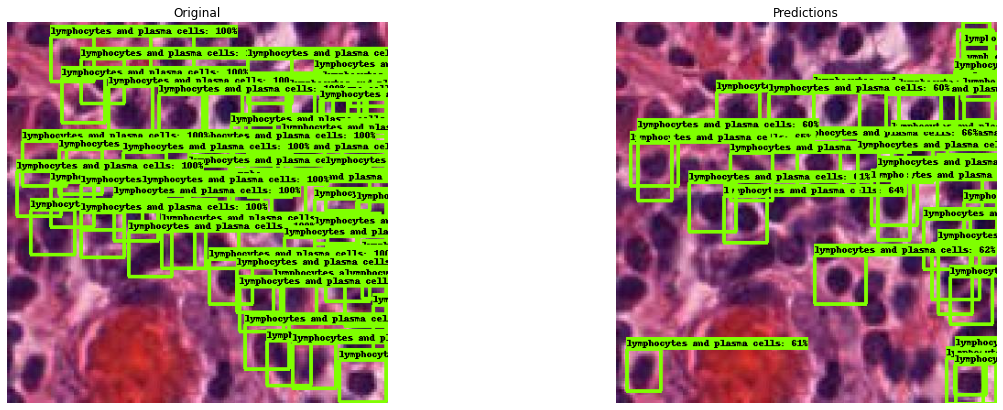

In [ ]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.60)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");

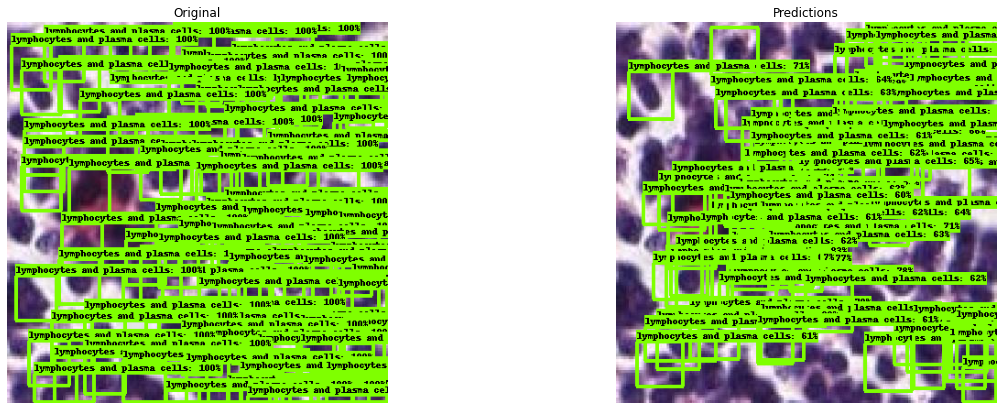

In [ ]:
idx = np.random.randint(len(test_df))

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.60)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off");